<a href="https://colab.research.google.com/github/Kelly0604/ECE661_Final/blob/main/Ensemble_Defense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Preprocessing for CIFAR-10
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for both ViT and BiT models
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [2]:
from timm import create_model
import torch.nn as nn
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load ViT-L-16 model
model_vit = create_model('vit_large_patch16_224', pretrained=True)
model_vit.head = nn.Linear(model_vit.head.in_features, 10)  # Modify for CIFAR-10
model_vit = model_vit.to(device)

# Load BiT-M-101x3 model
model_bit = create_model('resnetv2_101x3_bitm', pretrained=True)
num_features = model_bit.num_features  # Get the number of input features for the classification head
model_bit.head = nn.Linear(num_features, 10)  # Modify to match 10 classes for CIFAR-10
model_bit = model_bit.to(device)


# Update BiT-M classification head
model_bit.head = nn.Sequential(
    nn.AdaptiveAvgPool2d((1, 1)),  # Global Average Pooling: [B, C, H, W] -> [B, C, 1, 1]
    nn.Flatten(),                  # Flatten: [B, C, 1, 1] -> [B, C]
    nn.Linear(6144, 10)            # Fully Connected: [B, C] -> [B, 10]
)

# Set both models to evaluation mode
model_vit.eval()
model_bit.eval()

print("Models successfully loaded and modified for CIFAR-10.")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name resnetv2_101x3_bitm to current resnetv2_101x3_bit.goog_in21k_ft_in1k.
  model = create_fn(


Models successfully loaded and modified for CIFAR-10.


In [3]:
import random

def majority_voting(models, images):
    """
    Combines predictions from models using majority voting.
    """
    predictions = [torch.argmax(model(images), dim=1) for model in models]
    # Stack predictions and find the mode (most common class per sample)
    stacked_preds = torch.stack(predictions, dim=0)
    majority_preds = torch.mode(stacked_preds, dim=0)[0]
    return majority_preds

def random_selection(models, images):
    """
    Selects a single model randomly to evaluate the images.
    """
    chosen_model = random.choice(models)
    outputs = chosen_model(images)
    return torch.argmax(outputs, dim=1)


Evaluate the ensemble on clean data:

In [4]:
def evaluate_ensemble(models, loader, method="majority"):
    """
    Evaluates ensemble robustness on clean data.
    Args:
        models: List of models in the ensemble.
        loader: DataLoader with clean or adversarial examples.
        method: "majority" or "random" for ensemble method.

    Returns:
        Accuracy of the ensemble.
    """
    correct = 0
    total = 0

    # Ensure all models are on the same device
    for model in models:
        model.to(device)

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        if method == "majority":
            preds = majority_voting(models, images)
        elif method == "random":
            preds = random_selection(models, images)
        else:
            raise ValueError("Unknown ensemble method!")

        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Ensemble {method} accuracy: {accuracy:.2f}%")
    return accuracy


In [5]:
models = [model_vit, model_bit]

In [ ]:
# Evaluate on clean data
evaluate_ensemble(models, test_loader, method="majority")
evaluate_ensemble(models, test_loader, method="random")

Ensemble majority accuracy: 9.61%
Ensemble random accuracy: 6.57%


6.57

### White-box Attacks on ensemble:

In [10]:
# conenct to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import os
os.chdir('/content/drive/MyDrive/661FinalProject')

In [12]:
from AttackWrappersWhiteBoxP import FGSMNativePytorch, MIMNativePytorch

FGSM ensemble:

In [13]:
# FGSM for ensemble models
def FGSMEnsemble(device, dataLoader, models, epsilonMax, clipMin, clipMax, targeted):
    """
    FGSM attack on ensemble models with majority voting.
    """
    model_outputs = []
    for model in models:
        # Generate adversarial examples for each model
        model.eval()
        adv_loader = FGSMNativePytorch(
            device=device,
            dataLoader=dataLoader,
            model=model,
            epsilonMax=epsilonMax,
            clipMin=clipMin,
            clipMax=clipMax,
            targeted=targeted
        )
        model_outputs.append(adv_loader)

    # Combine results using majority voting
    return adv_loader

In [ ]:
# Parameters for FGSM
epsilon_FGSM = 0.031  # Perturbation magnitude
clip_min, clip_max = 0.0, 1.0  # Input clipping bounds
targeted = False  # False for untargeted attacks

# FGSM attack on ensemble
adv_loader_FGSM_ensemble = FGSMEnsemble(
    device=device,
    dataLoader=test_loader,
    models=models,
    epsilonMax=epsilon_FGSM,
    clipMin=clip_min,
    clipMax=clip_max,
    targeted=targeted
)

In [ ]:
# Evaluate ensemble on FGSM adversarial examples
print("Evaluating FGSM adversarial examples for the ensemble:")
evaluate_ensemble(models, adv_loader_FGSM_ensemble, method="majority")

Evaluating FGSM adversarial examples for the ensemble:
Ensemble majority accuracy: 9.16%


9.16

In [ ]:
evaluate_ensemble(models, adv_loader_FGSM_ensemble, method="random")

Ensemble random accuracy: 7.29%


7.29

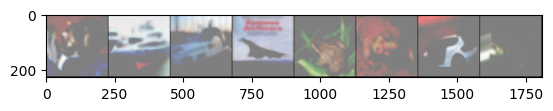

In [30]:
import matplotlib.pyplot as plt
import torchvision
# Get a batch of adversarial examples
for adv_images, labels in adv_loader_FGSM_ensemble:
    break

# Unnormalize for visualization
adv_images = adv_images * 0.5 + 0.5

# Show the images
grid = torchvision.utils.make_grid(adv_images[:8])
plt.imshow(grid.permute(1, 2, 0))
plt.show()

MIM ensemble:

In [31]:
# MIM for ensemble models
def MIMEnsemble(device, dataLoader, models, decayFactor, epsilonMax, epsilonStep, numSteps, clipMin, clipMax, targeted):
    """
    MIM attack on ensemble models with majority voting.
    """
    model_outputs = []
    for model in models:
        # Generate adversarial examples for each model
        model.eval()
        adv_loader = MIMNativePytorch(
            device=device,
            dataLoader=dataLoader,
            model=model,
            decayFactor=decayFactor,
            epsilonMax=epsilonMax,
            epsilonStep=epsilonStep,
            numSteps=numSteps,
            clipMin=clipMin,
            clipMax=clipMax,
            targeted=targeted
        )
        model_outputs.append(adv_loader)

    # Combine results using majority voting
    return adv_loader

In [35]:
# Parameters for MIM
epsilon_MIM = 0.031  # Maximum perturbation magnitude
epsilon_step_MIM = 0.00155  # Step size for each iteration
num_steps_MIM = 1  # Number of attack iterations
decay_factor_MIM = 1.0  # Momentum decay factor

# MIM attack on ensemble
adv_loader_MIM_ensemble = MIMEnsemble(
    device=device,
    dataLoader=test_loader,
    models=models,
    decayFactor=decay_factor_MIM,
    epsilonMax=epsilon_MIM,
    epsilonStep=epsilon_step_MIM,
    numSteps=num_steps_MIM,
    clipMin=clip_min,
    clipMax=clip_max,
    targeted=targeted
)

Processing up to sample= 64
Processing up to sample= 128
Processing up to sample= 192
Processing up to sample= 256
Processing up to sample= 320
Processing up to sample= 384
Processing up to sample= 448
Processing up to sample= 512
Processing up to sample= 576
Processing up to sample= 640
Processing up to sample= 704
Processing up to sample= 768
Processing up to sample= 832
Processing up to sample= 896
Processing up to sample= 960
Processing up to sample= 1024
Processing up to sample= 1088
Processing up to sample= 1152
Processing up to sample= 1216
Processing up to sample= 1280
Processing up to sample= 1344
Processing up to sample= 1408
Processing up to sample= 1472
Processing up to sample= 1536
Processing up to sample= 1600
Processing up to sample= 1664
Processing up to sample= 1728
Processing up to sample= 1792
Processing up to sample= 1856
Processing up to sample= 1920
Processing up to sample= 1984
Processing up to sample= 2048
Processing up to sample= 2112
Processing up to sample= 2

In [36]:
# Evaluate ensemble on MIM adversarial examples
print("Evaluating MIM adversarial examples for the ensemble:")
evaluate_ensemble(models, adv_loader_MIM_ensemble, method="majority")
evaluate_ensemble(models, adv_loader_MIM_ensemble, method="random")

Evaluating MIM adversarial examples for the ensemble:
Ensemble majority accuracy: 8.67%
Ensemble random accuracy: 7.43%


7.43

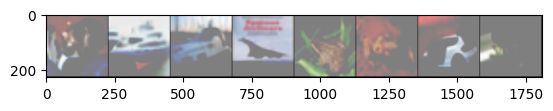

In [37]:
# Get a batch of adversarial examples
for adv_images, labels in adv_loader_MIM_ensemble:
    break

# Unnormalize for visualization
adv_images = adv_images * 0.5 + 0.5

# Show the images
grid = torchvision.utils.make_grid(adv_images[:8])
plt.imshow(grid.permute(1, 2, 0))
plt.show()

PGD Ensemble:

In [8]:
def PGDNativeEnsemble(device, dataLoader, models, epsilonMax, epsilonStep, numSteps, clipMin, clipMax, targeted, method="majority"):
    """
    Implements PGD attack for an ensemble with majority voting or random selection.
    """
    # Ensure all models are on the same device
    for model in models:
        model.to(device)
        model.eval()

    # Generate variables for storing the adversarial examples
    numSamples = len(dataLoader.dataset)
    xShape = next(iter(dataLoader))[0].shape[1:]  # Get input shape from DataLoader
    xAdv = torch.zeros(numSamples, *xShape).to(device)
    yClean = torch.zeros(numSamples, dtype=torch.long).to(device)

    advSampleIndex = 0
    for xData, yData in dataLoader:
        xData, yData = xData.to(device), yData.to(device)
        batchSize = xData.shape[0]
        advImages = xData.clone().detach()

        # PGD iterations
        for _ in range(numSteps):
            advImages.requires_grad = True

            # Get gradients using the ensemble strategy
            if method == "majority":
                grads = [torch.autograd.grad(torch.nn.CrossEntropyLoss()(model(advImages), yData), advImages, retain_graph=True)[0]
                         for model in models]
                ensemble_grad = torch.stack(grads).mean(dim=0)  # Average gradients across models
            elif method == "random":
                chosen_model = random.choice(models)
                ensemble_grad = torch.autograd.grad(torch.nn.CrossEntropyLoss()(chosen_model(advImages), yData), advImages)[0]
            else:
                raise ValueError("Unknown ensemble method!")

            # Generate adversarial perturbations
            gradSign = ensemble_grad.sign()
            if targeted:
                advImages = advImages - epsilonStep * gradSign  # Targeted: decrease towards target
            else:
                advImages = advImages + epsilonStep * gradSign  # Untargeted: increase loss

            # Project adversarial examples to epsilon-ball and clip to valid range
            advImages = torch.clamp(advImages, xData - epsilonMax, xData + epsilonMax)
            advImages = torch.clamp(advImages, clipMin, clipMax).detach()

            # Release GPU memory
            torch.cuda.empty_cache()

        # Save adversarial examples
        for j in range(batchSize):
            xAdv[advSampleIndex] = advImages[j]
            yClean[advSampleIndex] = yData[j]
            advSampleIndex += 1

    # Return DataLoader with adversarial examples
    advLoader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(xAdv.cpu(), yClean.cpu()),  # Convert to CPU for DataLoader
        batch_size=dataLoader.batch_size,
        shuffle=False
    )
    return advLoader

In [9]:
# PGD parameters for CIFAR-10 from Table 4
epsilon = 0.031  # Maximum perturbation magnitude
epsilon_step = 0.00155  # Step size for each iteration
num_steps = 20  # Number of attack iterations
clip_min = 0.0  # Minimum pixel value
clip_max = 1.0  # Maximum pixel value
targeted = False  # Untargeted attack

# Generate PGD adversarial examples for the ensemble
adv_loader_PGD_ensemble = PGDNativeEnsemble(
    device=device,
    dataLoader=test_loader,
    models=models,  # ViT and BiT ensemble
    epsilonMax=epsilon,
    epsilonStep=epsilon_step,
    numSteps=num_steps,
    clipMin=clip_min,
    clipMax=clip_max,
    targeted=targeted,
    method="majority"  # Majority voting
)

print("PGD attack completed for the ensemble!")

PGD attack completed for the ensemble!


In [11]:
# Evaluate on adversarial examples
ensemble_majority_accuracy = evaluate_ensemble(models, adv_loader_PGD_ensemble, method="majority")
print(f"Ensemble majority accuracy on PGD adversarial examples: {ensemble_majority_accuracy:.2f}%")

Ensemble majority accuracy: 0.01%
Ensemble majority accuracy on PGD adversarial examples: 0.01%


APGD Ensemble:

In [6]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchattacks import APGD
from tqdm import tqdm

def APGDNativeEnsemble(
    device, dataLoader, models, epsilonMax, numSteps, clipMin, clipMax, decision_fn, restarts=1, rho=0.75, max_queries=5000
):
    """
    Implements the APGD attack for an ensemble with improved memory management and tqdm progress bar.

    Args:
        device (torch.device): Device for computations.
        dataLoader (DataLoader): DataLoader for clean test images.
        models (list): List of target models.
        epsilonMax (float): Maximum perturbation magnitude.
        numSteps (int): Number of attack iterations.
        clipMin (float): Minimum pixel value.
        clipMax (float): Maximum pixel value.
        decision_fn (function): Decision function for the ensemble (e.g., majority voting or random selection).
        restarts (int): Number of restarts (default: 1).
        rho (float): Early stopping threshold (default: 0.75).
        max_queries (int): Maximum number of queries per sample (default: 5000).

    Returns:
        DataLoader: DataLoader containing adversarial examples and their true labels.
    """
    for model in models:
        model.eval()
        model.to(device)  # Move all models to the specified device

    # Initialize attack using the first model as base
    attack = APGD(models[0], eps=epsilonMax, steps=numSteps, n_restarts=restarts)
    numSamples = len(dataLoader.dataset)
    xShape = next(iter(dataLoader))[0].shape[1:]

    # Initialize storage tensors on CPU to reduce GPU memory usage
    xAdv = torch.zeros(numSamples, *xShape, device='cpu')
    yClean = torch.zeros(numSamples, dtype=torch.long, device='cpu')

    advSampleIndex = 0
    query_count = 0

    # Add tqdm progress bar for batches
    for xData, yData in tqdm(dataLoader, desc="Generating adversarial examples", unit="batch"):
        xData, yData = xData.to(device), yData.to(device)

        # Early stopping mechanism
        for restart in range(restarts):
            if query_count >= max_queries:
                break  # Stop if query budget is reached

            try:
                # Generate adversarial examples
                advImages = attack(xData, yData)
                query_count += xData.size(0)

                # Ensemble decision
                preds = decision_fn(models, advImages)
                success_rate = ((preds != yData).sum().item()) / yData.size(0)

                if success_rate >= rho:  # Early stopping
                    break

            except RuntimeError as e:
                if "CUDA out of memory" in str(e):
                    print("CUDA out of memory. Skipping current batch...")
                    torch.cuda.empty_cache()
                    continue
                else:
                    raise e

        # Save adversarial examples
        batchSize = xData.shape[0]
        for j in range(batchSize):
            xAdv[advSampleIndex] = advImages[j].cpu()
            yClean[advSampleIndex] = yData[j].cpu()
            advSampleIndex += 1

        # Release GPU memory
        del advImages
        torch.cuda.empty_cache()

    # Return DataLoader with adversarial examples
    advLoader = DataLoader(
        TensorDataset(xAdv, yClean),  # Ensure tensors are stored on CPU
        batch_size=dataLoader.batch_size,
        shuffle=False
    )
    return advLoader


In [7]:
# Parameters for APGD Ensemble Attack
epsilon = 0.031
num_steps = 50
restarts = 1
rho = 0.75
max_queries = 5000
clip_min = 0.0
clip_max = 1.0

# Perform APGD Attack on Ensemble with Majority Voting
adv_loader_APGD_ensemble_majority = APGDNativeEnsemble(
    device=device,
    dataLoader=test_loader,
    models=[model_vit, model_bit],
    epsilonMax=epsilon,
    numSteps=num_steps,
    clipMin=clip_min,
    clipMax=clip_max,
    decision_fn=majority_voting,  # Use majority voting
    restarts=restarts,
    rho=rho,
    max_queries=max_queries
)


Generating adversarial examples:  50%|█████     | 79/157 [07:05<07:00,  5.39s/batch]


UnboundLocalError: local variable 'advImages' referenced before assignment

In [ ]:
# Evaluate Ensemble Performance on APGD Adversarial Examples
print("Evaluating APGD adversarial examples for the ensemble (Majority Voting):")
evaluate_ensemble(models, adv_loader_APGD_ensemble_majority, method="majority")

BPDA ensemble:

In [6]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

def BPDAEnsemble(
    device, dataLoader, models, epsilonMax, numSteps, learning_rate, clipMin, clipMax
):
    """
    Implements the BPDA attack for an ensemble of models with the specified parameters.
    Args:
        device (torch.device): Device for computations.
        dataLoader (DataLoader): DataLoader for clean test images.
        models (list): List of target models.
        epsilonMax (float): Maximum perturbation magnitude.
        numSteps (int): Number of attack iterations.
        learning_rate (float): Learning rate for gradient updates.
        clipMin (float): Minimum pixel value.
        clipMax (float): Maximum pixel value.

    Returns:
        DataLoader: DataLoader containing adversarial examples and their true labels.
    """
    for model in models:
        model.eval()
        model.to(device)

    numSamples = len(dataLoader.dataset)
    xShape = next(iter(dataLoader))[0].shape[1:]
    xAdv = torch.zeros(numSamples, *xShape, device=device)
    yClean = torch.zeros(numSamples, dtype=torch.long, device=device)

    advSampleIndex = 0

    # Add tqdm for batch processing
    for batch_index, (xData, yData) in enumerate(tqdm(dataLoader, desc="Processing Batches")):
        xData, yData = xData.to(device), yData.to(device)
        advImages = xData.clone().detach()

        for step in tqdm(range(numSteps), desc=f"Optimizing Batch {batch_index + 1}/{len(dataLoader)}"):
            advImages.requires_grad = True

            # Aggregate gradients from all models
            gradients = []
            for model in models:
                outputs = model(advImages)
                loss = torch.nn.CrossEntropyLoss()(outputs, yData)
                model.zero_grad()
                loss.backward()
                gradients.append(advImages.grad.data.clone())
                advImages.grad.zero_()

            # Average gradients across all models
            avgGradient = torch.mean(torch.stack(gradients), dim=0)

            # Apply perturbation
            advImages = advImages + learning_rate * avgGradient.sign()
            advImages = torch.clamp(advImages, xData - epsilonMax, xData + epsilonMax)
            advImages = torch.clamp(advImages, clipMin, clipMax).detach()

        # Save adversarial examples
        batchSize = xData.shape[0]
        for j in range(batchSize):
            xAdv[advSampleIndex] = advImages[j]
            yClean[advSampleIndex] = yData[j]
            advSampleIndex += 1

        # Release GPU memory
        del advImages
        torch.cuda.empty_cache()

    # Return DataLoader with adversarial examples
    advLoader = DataLoader(
        TensorDataset(xAdv.cpu(), yClean.cpu()),
        batch_size=dataLoader.batch_size,
        shuffle=False
    )
    return advLoader

In [7]:
# Parameters for BPDA Ensemble Attack
epsilon = 0.031
num_steps = 10  # Number of steps
learning_rate = 0.5  # Learning rate
clip_min = 0.0
clip_max = 1.0

# Perform BPDA Attack on Ensemble
adv_loader_BPDA_ensemble = BPDAEnsemble(
    device=device,
    dataLoader=test_loader,
    models=[model_vit, model_bit],
    epsilonMax=epsilon,
    numSteps=num_steps,
    learning_rate=learning_rate,
    clipMin=clip_min,
    clipMax=clip_max
)

# Evaluate Ensemble Performance on BPDA Adversarial Examples
print("Evaluating BPDA adversarial examples for the ensemble:")
evaluate_ensemble([model_vit, model_bit], adv_loader_BPDA_ensemble, method="majority")

Processing Batches: 100%|██████████| 157/157 [49:23<00:00, 18.87s/it]


Evaluating BPDA adversarial examples for the ensemble:
Ensemble majority accuracy: 1.37%


1.37

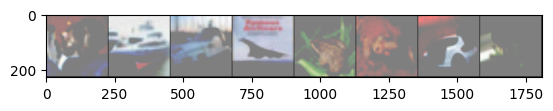

In [13]:
import torchvision
import matplotlib.pyplot as plt

# Get a batch of adversarial examples
for adv_images, labels in adv_loader_BPDA_ensemble:
    break

# Unnormalize for visualization
adv_images = adv_images * 0.5 + 0.5

# Show the images
grid = torchvision.utils.make_grid(adv_images[:8])
plt.imshow(grid.permute(1, 2, 0))
plt.show()

CW ensemble:

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

def CWEnsemble(
    device, dataLoader, models, confidence, step_size, num_steps, clipMin, clipMax
):
    """
    Implements the CW attack for an ensemble of models.
    Args:
        device (torch.device): Device for computations.
        dataLoader (DataLoader): DataLoader for clean test images.
        models (list): List of target models.
        confidence (float): Confidence margin for misclassification.
        step_size (float): Step size for gradient update.
        num_steps (int): Number of attack iterations.
        clipMin (float): Minimum pixel value.
        clipMax (float): Maximum pixel value.

    Returns:
        DataLoader: DataLoader containing adversarial examples and their true labels.
    """
    for model in models:
        model.eval()
        model.to(device)

    numSamples = len(dataLoader.dataset)
    xShape = next(iter(dataLoader))[0].shape[1:]
    xAdv = torch.zeros(numSamples, *xShape, device=device)
    yClean = torch.zeros(numSamples, dtype=torch.long, device=device)

    advSampleIndex = 0

    def cw_loss(outputs, y):
        """
        CW loss: minimize the logits difference between the true label and the best wrong class.
        """
        one_hot_labels = F.one_hot(y, num_classes=outputs.size(-1)).float()
        correct_class_logits = torch.sum(one_hot_labels * outputs, dim=1)
        wrong_class_logits, _ = torch.max((1 - one_hot_labels) * outputs - one_hot_labels * confidence, dim=1)
        return torch.sum(F.relu(correct_class_logits - wrong_class_logits))

    for xData, yData in dataLoader:
        xData, yData = xData.to(device), yData.to(device)
        advImages = xData.clone().detach()

        for step in range(num_steps):
            advImages.requires_grad = True

            # Aggregate gradients from all models
            gradients = []
            for model in models:
                outputs = model(advImages)
                loss = cw_loss(outputs, yData)
                model.zero_grad()
                loss.backward()
                gradients.append(advImages.grad.data.clone())
                advImages.grad.zero_()

            # Average gradients across all models
            avgGradient = torch.mean(torch.stack(gradients), dim=0)

            # Apply perturbation
            advImages = advImages - step_size * avgGradient
            advImages = torch.clamp(advImages, clipMin, clipMax).detach()

        # Save adversarial examples
        batchSize = xData.shape[0]
        for j in range(batchSize):
            xAdv[advSampleIndex] = advImages[j]
            yClean[advSampleIndex] = yData[j]
            advSampleIndex += 1

        # Release GPU memory
        del advImages
        torch.cuda.empty_cache()

    # Return DataLoader with adversarial examples
    advLoader = DataLoader(
        TensorDataset(xAdv.cpu(), yClean.cpu()),
        batch_size=dataLoader.batch_size,
        shuffle=False
    )
    return advLoader


In [ ]:
# Parameters for CW Attack
confidence = 50  # Confidence margin
step_size = 0.00155  # Gradient step size
num_steps = 30  # Number of steps
clip_min = 0.0
clip_max = 1.0

# Perform CW Attack on Ensemble
adv_loader_CW_ensemble = CWEnsemble(
    device=device,
    dataLoader=test_loader,
    models=[model_vit, model_bit],
    confidence=confidence,
    step_size=step_size,
    num_steps=num_steps,
    clipMin=clip_min,
    clipMax=clip_max
)

# Evaluate Ensemble Performance on CW Adversarial Examples
print("Evaluating CW adversarial examples for the ensemble:")
evaluate_ensemble([model_vit, model_bit], adv_loader_CW_ensemble, method="majority")

###Transferability Test:

In [18]:
# Loading ViT-32
import torch
from timm import create_model

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the ViT model (ensure num_classes matches CIFAR-10)
vit_model = create_model('vit_base_patch32_224', pretrained=False, num_classes=10)
vit_model = vit_model.to(device)

# Load the pretrained weights for ViT
checkpoint_path = "vit_b32_cifar10.pth"  # Replace with your ViT weights path
vit_model.load_state_dict(torch.load(checkpoint_path, map_location=device))

<ipython-input-18-ba8ad6869300>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit_model.load_state_dict(torch.load(checkpoint_path, map_location=device))


<All keys matched successfully>

In [19]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Define transformations for ViT
vit_transform_train = transforms.Compose([
    transforms.Resize(224),  # Resize to 224x224 for ViT
    transforms.RandomCrop(224, padding=4),  # Optional data augmentation
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to [-1, 1]
])

vit_transform_test = transforms.Compose([
    transforms.Resize(224),  # Resize to 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to [-1, 1]
])

# Load CIFAR-10 dataset with ViT transformations
vit_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=vit_transform_train)
vit_test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=vit_transform_test)

# Create DataLoaders for ViT
vit_train_loader = DataLoader(vit_train_dataset, batch_size=64, shuffle=True, num_workers=2)
vit_test_loader = DataLoader(vit_test_dataset, batch_size=64, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [20]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import Resize

# Function to resize adversarial examples
def resize_adv_loader(adv_loader, target_size, device):
    """
    Resize adversarial examples to match the target model's input size.

    Args:
        adv_loader (DataLoader): DataLoader containing adversarial examples and labels.
        target_size (tuple): Target size (height, width) for resizing.
        device (torch.device): Device for computations.

    Returns:
        DataLoader: DataLoader with resized adversarial examples.
    """
    resized_images = []
    resized_labels = []

    for images, labels in adv_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Resize images
        resized = torch.nn.functional.interpolate(images, size=target_size, mode='bilinear', align_corners=False)
        resized_images.append(resized.cpu())
        resized_labels.append(labels.cpu())

    # Concatenate resized images and labels
    resized_images = torch.cat(resized_images)
    resized_labels = torch.cat(resized_labels)

    # Create a new DataLoader
    dataset = TensorDataset(resized_images, resized_labels)
    resized_loader = DataLoader(dataset, batch_size=adv_loader.batch_size, shuffle=False)

    return resized_loader

In [25]:
def evaluate_transferability(target_model, adv_loader, device):
    target_model.eval()
    correct = 0
    total = 0

    for adv_images, labels in adv_loader:
        adv_images, labels = adv_images.to(device), labels.to(device)

        # Test adversarial examples on the target model
        outputs = target_model(adv_images)
        _, predicted = outputs.max(1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total
    transfer_success_rate = 100.0 * (1 - correct / total)

    return {
        'accuracy': accuracy,
        'transfer_success_rate': transfer_success_rate,
        'total_samples': total
    }


In [26]:
# Resize adversarial examples if needed
adv_loader_resized_BPDA_ensemble = resize_adv_loader(
    adv_loader_BPDA_ensemble,
    target_size=(224, 224),  # Adjust target size based on your model's input requirement
    device=device
)

# Evaluate the target model on resized BPGD ensemble adversarial examples
results_BPDA_ensemble = evaluate_transferability(
    target_model=vit_model,
    adv_loader=adv_loader_resized_BPDA_ensemble,
    device=device
)

# Display the results
print(f"Accuracy: {results_BPDA_ensemble['accuracy']:.2f}%")
print(f"Transferability Success Rate: {results_BPDA_ensemble['transfer_success_rate']:.2f}%")


Accuracy: 43.16%
Transferability Success Rate: 56.84%
